In [17]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
import torch


class FlexibleMISEnvironment(gym.Env):
    def __init__(self, adjacency_matrix):
        super(FlexibleMISEnvironment, self).__init__()
        self.adj_matrix = np.array(adjacency_matrix)
        self.num_nodes = len(adjacency_matrix)
        
        # Define action and observation space
        self.action_space = spaces.Discrete(self.num_nodes)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.num_nodes,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_set = set()
        self.available_nodes = set(range(self.num_nodes))
        return self._get_state(), {}  # Return state and info dict

    def step(self, action):
        reward = 0
        terminated = False
        truncated = False
        
        if action in self.available_nodes:
            self.current_set.add(action)
            self.available_nodes -= set([action] + np.where(self.adj_matrix[action] == 1)[0].tolist())
            reward = 1
            terminated = len(self.available_nodes) == 0
        else:
            reward = -1
            terminated = True
        
        return self._get_state(), reward, terminated, truncated, {}  # State, reward, terminated, truncated, info

    def _get_state(self):
        state = np.zeros(self.num_nodes, dtype=np.float32)
        state[list(self.current_set)] = 1
        state[list(self.available_nodes)] = 0.5
        return state

class FlexibleFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 64):
        super(FlexibleFeatureExtractor, self).__init__(observation_space, features_dim=features_dim)
        n_input = observation_space.shape[0]
        self.net = nn.Sequential(
            nn.Linear(n_input, 128),
            nn.ReLU(),
            nn.Linear(128, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.net(observations)

def create_ppo_model(env, features_dim=64):
    policy_kwargs = dict(
        features_extractor_class=FlexibleFeatureExtractor,
        features_extractor_kwargs=dict(features_dim=features_dim),
    )
    return PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1)

def generate_random_graph(num_nodes, edge_probability=0.2):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if np.random.random() < edge_probability:
                adjacency_matrix[i][j] = adjacency_matrix[j][i] = 1
    return adjacency_matrix.tolist()

def visualize_graph_and_mis(adjacency_matrix, mis):
    G = nx.Graph()
    num_nodes = len(adjacency_matrix)
    G.add_nodes_from(range(num_nodes))
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adjacency_matrix[i][j] == 1:
                G.add_edge(i, j)

    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G)

    nx.draw_networkx_edges(G, pos, alpha=0.2)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=300)
    nx.draw_networkx_labels(G, pos, font_size=8)

    nx.draw_networkx_nodes(G, pos, nodelist=list(mis), node_color='red', node_size=400)

    plt.title(f"{num_nodes}-Node Graph with Maximum Independent Set (highlighted in red)", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def train_mis_model(num_vertices, num_graphs=100, training_steps=10000):
    def create_env():
        return FlexibleMISEnvironment(generate_random_graph(num_vertices))

    env = DummyVecEnv([create_env for _ in range(num_graphs)])
    model = create_ppo_model(env, features_dim=num_vertices)
    model.learn(total_timesteps=training_steps)
    return model

def infer_mis(model, adjacency_matrix):
    env = DummyVecEnv([lambda: FlexibleMISEnvironment(adjacency_matrix)])
    obs = env.reset()
    done = False
    mis = set()

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = env.step(action)
        done = dones[0]
        if rewards[0] > 0:
            mis.add(action[0])

    return mis

def solve_and_visualize_mis_inference(model, adjacency_matrix):
    mis = infer_mis(model, adjacency_matrix)
    print(f"Maximum Independent Set: {mis}")
    visualize_graph_and_mis(adjacency_matrix, mis)

# Example usage
num_vertices = 15
training_steps = 200000

# Train the model
trained_model = train_mis_model(num_vertices, num_graphs=50, training_steps=training_steps)



Using cpu device
-------------------------------
| time/              |        |
|    fps             | 110408 |
|    iterations      | 1      |
|    time_elapsed    | 0      |
|    total_timesteps | 102400 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 12193       |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.03000198  |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.69       |
|    explained_variance   | 0.008357406 |
|    learning_rate        | 0.0003      |
|    loss                 | 0.392       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0214     |
|    value_loss           | 0.946       |
-----------------------------------------


Maximum Independent Set: {np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(10)}


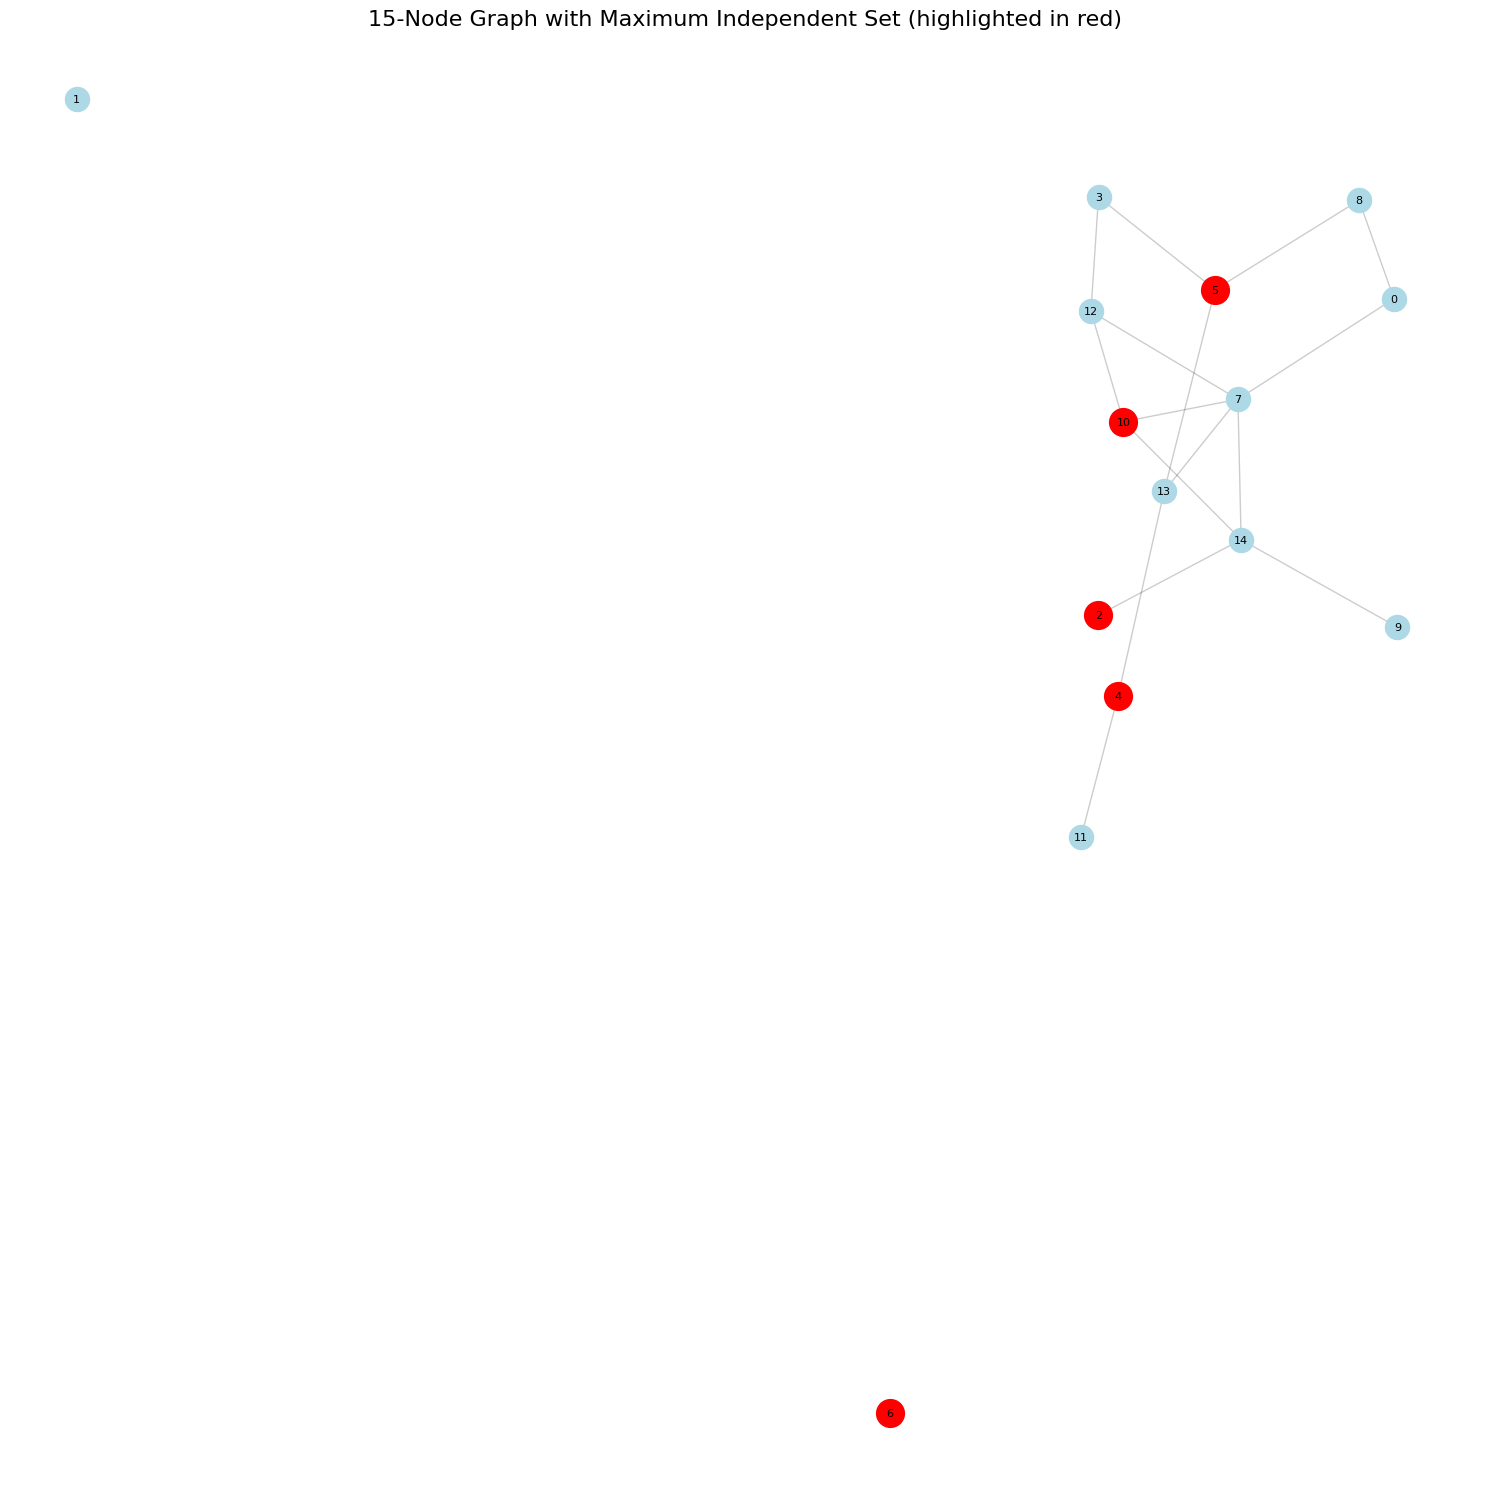

In [18]:
# Generate a new random graph externally
new_graph = generate_random_graph(num_vertices, edge_probability=0.2)

# Infer and visualize MIS on the externally generated graph
solve_and_visualize_mis_inference(trained_model, new_graph)